In [10]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/palmer/Documents/python_codebase/')
from pyMS.centroid_detection import gradient
from pyImagingMSpec.hdf5.inMemoryIMS_hdf5 import inMemoryIMS_hdf5
from pyImagingMSpec.image_measures import level_sets_measure
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import bokeh as bk
from bokeh.plotting import output_notebook 
output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
filename_in =  '/Volumes/alexandr/shared/Luca/20150824_ADP_LR_Finger_Print_FullScan_DHBsub_80x80_15um.hdf5' #using a temporary hdf5 based format
save_dir='/Volumes/alexandr/shared/Luca/20150824_ADP_LR_Finger_Print_FullScan_DHBsub_80x80_15um_images'

# Parse data
IMS_dataset=inMemoryIMS(filename_in)
ppm = 0.75

In [12]:
# Generate mean spectrum
#hist_axis,mean_spec =IMS_dataset.generate_summary_spectrum(summary_type='mean')
hist_axis,freq_spec =IMS_dataset.generate_summary_spectrum(summary_type='freq',ppm=ppm/2)

3583525


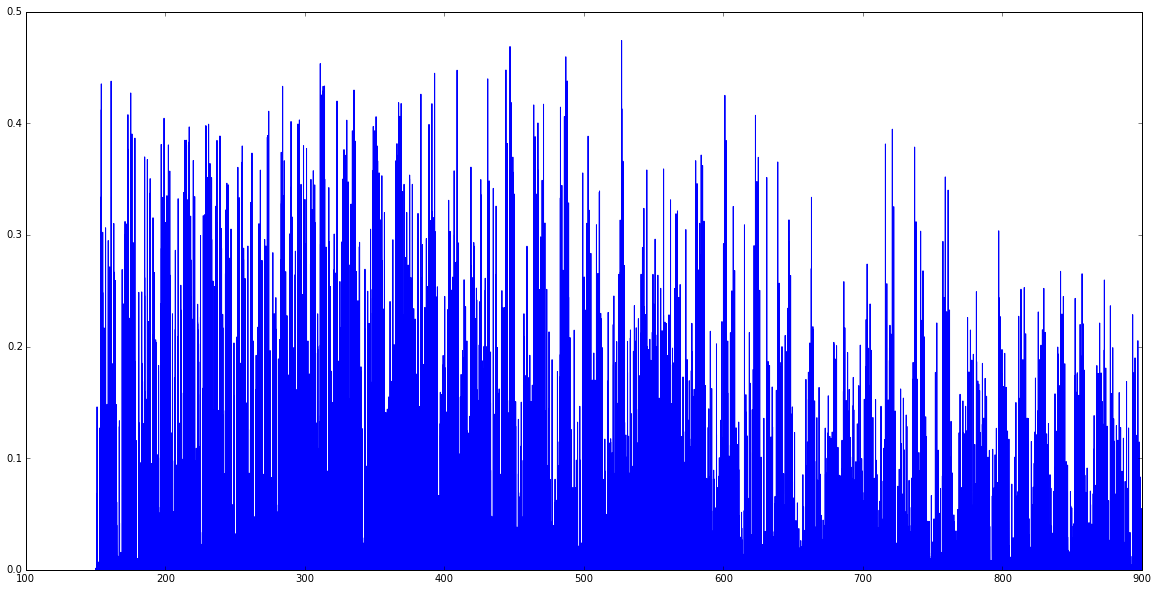

In [51]:
#p1 = bk.plotting.figure()
#p1.line(hist_axis,mean_spec/np.max(mean_spec),color='red')
#p1.line(hist_axis,freq_spec/np.max(freq_spec),color='orange')
#bk.plotting.show(p1)
print len(hist_axis)
plt.figure(figsize=(20,10))
plt.plot(hist_axis,freq_spec)
plt.show()

In [14]:
# Centroid detection of frequency spectrum
mz_list,count_list,idx_list = gradient(np.asarray(hist_axis),np.asarray(freq_spec),weighted_bins=2)

In [84]:
c_thresh=0.05
moc_thresh=0.99
print np.sum(count_list>c_thresh)

3508


In [46]:
# Calcualte MoC for images of all peaks
nlevels=30
im_list={}
for ii, c in enumerate(count_list):
    if c>c_thresh:
        ion_image = IMS_dataset.get_ion_image(np.asarray([mz_list[ii],]),ppm)
        im=ion_image.xic_to_image(0)
        m,im_moc,levels,nobjs = level_sets_measure.measure_of_chaos(im,nlevels,interp='median') #just output measure value
        m=1-m
        im_list[mz_list[ii]]={'image':im,'moc':m,'freq':c}

3508


In [70]:
from pySpatialMetabolomics.tools import colourmaps
c_map = colourmaps.get_colormap('vidris')#if black images: open->save->rerun
c_pal=[[int(255*cc) for cc in c_map(c)] for c in range(0,254)]

In [86]:
# Export all images
import png as pypng
for mz in im_list:
    if im_list[mz]['moc']>moc_thresh:
        with open('{}/{}_{}.png'.format(save_dir,mz,im_list[mz]['moc']),'wb') as f_out:
            im_out = im_list[mz]['image']
            im_out = 254*im_out/np.max(im_out)
            w,h = np.shape(im_out)
            w = pypng.Writer(h, w, palette=c_pal, bitdepth=8)
            w.write(f_out,im_out)


0.990424143958
333.334188269


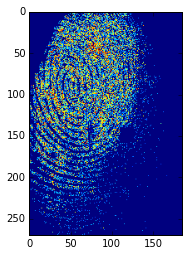

In [79]:
#im_out = im_list[mz]['image']
mz=333.334188269
ion_image = IMS_dataset.get_ion_image(np.asarray([mz,]),ppm)
im_out=ion_image.xic_to_image(0)
m,im_moc,levels,nobjs = level_sets_measure.measure_of_chaos(im,nlevels,interp='') #just output measure value
print 1-m
im_out = 254.*im_out/np.max(im_out)
print mz
#print im_list[mz]['moc']
plt.figure()
plt.imshow(im_moc)
plt.show()